## 1. Libraries

In [129]:
# Import necessary libraries for audio processing and analysis
import pandas as pd
import librosa
import soundfile
import os, glob, pickle # libraries for file handling and data manipulation
import numpy as np
import matplotlib.pyplot as plt # visualization library
import seaborn as sb # visualization library

# Import libraries for model training and evaluation
from sklearn.model_selection import train_test_split # for splitting data into training and testing sets
from sklearn.neural_network import MLPClassifier # for training a neural network model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Import libraries for audio visualization
import IPython.display as ipd
import librosa.display

# Import libraries for data preprocessing
# Normalization and Dimentionality
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA  # to apply PCA

from sklearn.preprocessing import LabelEncoder

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Loading the RAVDESS Dataset

In [130]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [131]:
modalities={
  # 1st
  '01':'full-AV',
  '02':'Video-only',
  '03':'audio-only',
}
vocals={
  # 2nd
  '01':'speech',
  '02':'song',
}
emotions={
  # 3rd
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
emotion_intensities={
  # 4th
  '01':'normal',
  '02':'strong',
  '03':'audio-only',
}
statements={
  # 5th
  '01':'Kids are talking by the door',
  '02':'Dogs are sitting by the door',
}
repetitions={
  #6th
  '01':'1st rep.',
  '02':'2nd rep.',
}

In [132]:
def load_data(test_size=0.2):
    x,y=[],[]
    df = pd.DataFrame()
    modality = []
    vocal = []
    statement = []
    repetition = []
    actor = []


    for file in glob.glob("Actor_*\\*.wav"):
        # print(file)
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        modality.append(modalities[file_name.split("-")[0]])
        vocal.append(vocals[file_name.split("-")[1]])
        emotion_intensity=emotion_intensities[file_name.split("-")[3]]
        statement.append(statements[file_name.split("-")[4]])
        repetition.append(repetitions[file_name.split("-")[5]])
        actor.append(file_name.split("-")[6].split(".")[0])
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    df['emotion'] = y
    df['modality'] = modality
    df['vocal'] = vocal
    df['emotion_intensity'] = emotion_intensity
    df['statement'] = statement
    df['repetition'] = repetition
    df['actor'] = actor
    df['feature'] = x
    return df 

## 3. Data

### 3.1. Pre-Processing

- Reading Data

In [133]:
df = pd.DataFrame()
df=load_data(test_size=0.25)

In [134]:
# number of rows and columns
df.shape

(1440, 8)

- Making actor column with male and female values

In [135]:
df['actor'] = df ['actor'].apply(lambda x : 'male' if int(x) % 2 != 0 else 'female')

In [136]:
df.sample(5)

,emotion,modality,vocal,emotion_intensity,statement,repetition,actor,feature
98,fearful,audio-only,speech,strong,Dogs are sitting by the door,1st rep.,female,"[-556.76220703125, 22.96605682373047, -24.6651..."
963,neutral,audio-only,speech,strong,Dogs are sitting by the door,2nd rep.,male,"[-614.436767578125, 65.10794067382812, 3.29360..."
1155,happy,audio-only,speech,strong,Dogs are sitting by the door,2nd rep.,female,"[-665.0882568359375, 22.926332473754883, -17.4..."
1367,disgust,audio-only,speech,strong,Dogs are sitting by the door,2nd rep.,male,"[-650.8666381835938, 40.36644744873047, 1.9513..."
833,surprised,audio-only,speech,strong,Kids are talking by the door,2nd rep.,female,"[-654.2483520507812, 31.6025447845459, -7.1705..."


In [137]:
# data appearance
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   emotion            1440 non-null   object
 1   modality           1440 non-null   object
 2   vocal              1440 non-null   object
 3   emotion_intensity  1440 non-null   object
 4   statement          1440 non-null   object
 5   repetition         1440 non-null   object
 6   actor              1440 non-null   object
 7   feature            1440 non-null   object
dtypes: object(8)
memory usage: 90.1+ KB


- Checking empty/missing values

In [138]:
df.isna().sum()

emotion              0
modality             0
vocal                0
emotion_intensity    0
statement            0
repetition           0
actor                0
feature              0
dtype: int64

### 3.2. Data Analysis

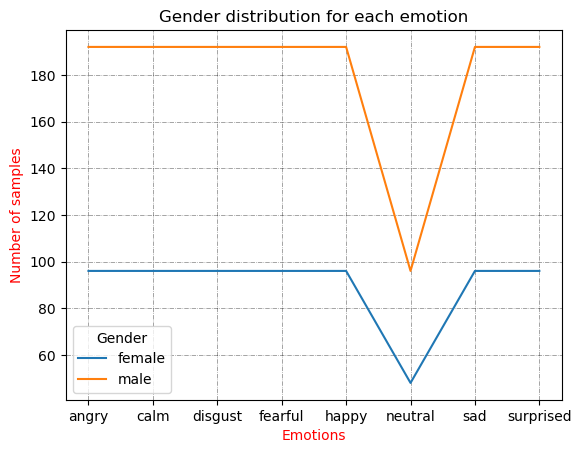

In [139]:
df.groupby(['emotion', 'actor']).size().unstack().plot(kind='line', stacked=True)
plt.title('Gender distribution for each emotion')
plt.xlabel('Emotions', color = 'red')
plt.ylabel('Number of samples', color = 'red')
# add legend and set position to upper left
plt.legend(loc= 'best', title = 'Gender')
# add grid with some adjustments 
plt.grid(color = "black", linewidth = "0.5", linestyle = "-.",alpha=0.5);

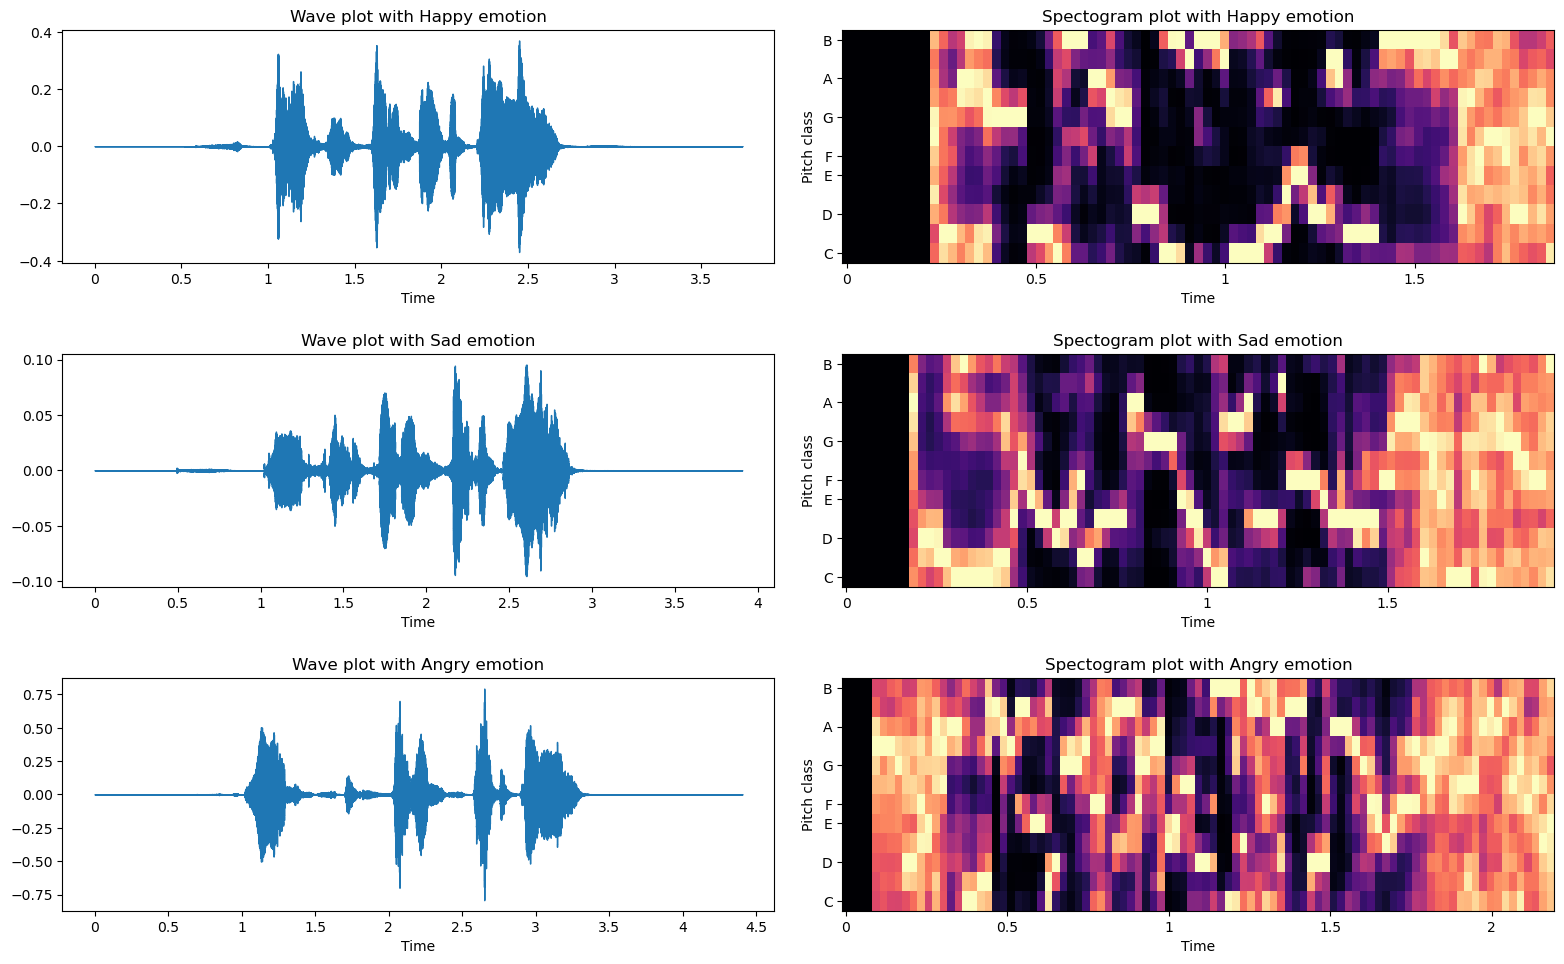

In [140]:
# file name manipulation for easy plotting
fname = 'Actor_14\\03-01-06-02-02-02-14.wav'  
parts = fname.split('-')
parts
lpart = parts[0] + '-' + parts[1] + '-'
rpart = '-' + parts[3] + '-' + parts[4] + '-' + parts[5]+ '-' + parts[6]

# multiple graphs in

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 10))
ax = ax.flatten()
index = 0
for i in range(3,6):
    if i == 3:
        title = 'Happy'
    elif i == 4:
        title = 'Sad'
    elif i == 5:
        title = 'Angry'
    fname = lpart + '0'+ str(i) + rpart
    # loading file
    data, sampling_rate = librosa.load(fname)

    # Wave plot
    librosa.display.waveshow(data, sr=sampling_rate, ax= ax[index])
    ax[index].set_title('Wave plot with ' + title + ' emotion')
    # Spectogram
    D = librosa.stft(data)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S = np.abs(librosa.stft(data, n_fft=4096))**2
    chroma = librosa.feature.chroma_stft(S=S, sr=sampling_rate)
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax= ax[index+1])
    ax[index + 1].set_title('Spectogram plot with ' + title + ' emotion')

    index +=2
plt.tight_layout(pad=2)
plt.show()
# Lets play the audio 
ipd.Audio(fname)

- Count of Emotions

Text(0.5, 1.0, 'Emotion counts')

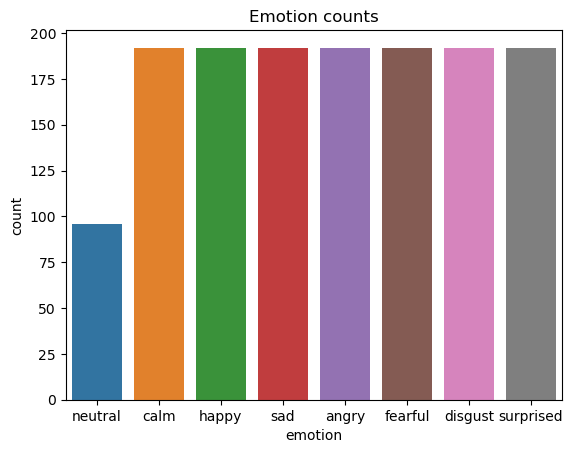

In [141]:
sb.countplot(x=df["emotion"])
plt.title('Emotion counts')

### 3.3 Preparation

- Remove Neutral emotions to balance the data

In [142]:
df = df[~df.emotion.isin(['neutral'])]
df.shape


(1344, 8)

- Count extracted features

In [143]:
feature = np.array(df['feature'])

print(f'Features extracted: {feature[1].shape}')


Features extracted: (180,)


- Defining x and y 

In [144]:
x = np.array(list(df['feature']))
y = list(df['emotion'])

### 3.4 Normailzation

In [145]:
scaler  =  MinMaxScaler()
x = scaler.fit_transform(x)


### 3.5 Dimentionality Reduction

- Create Principal Component Analysis with all features

In [146]:
pca = PCA(n_components=180)
pca.fit(x)

PCA(n_components=180)

- Plot cumulative variance

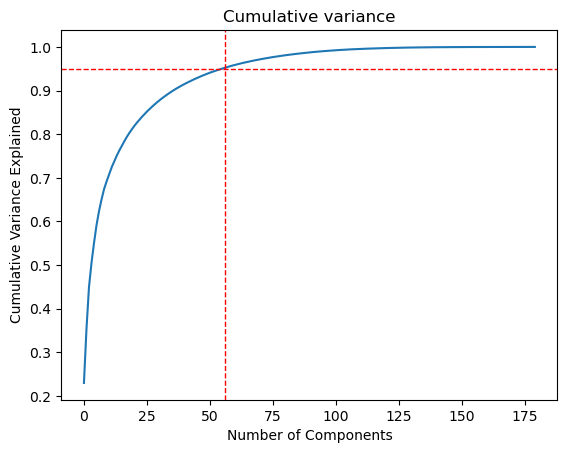

In [147]:
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative variance explained by the components
cumulative_variance = [explained_variance[0]]
for i in range(1, len(explained_variance)):
    cumulative_variance.append(cumulative_variance[i-1] + explained_variance[i])

# Create a line plot of the cumulative variance explained by the components
plt.plot(range(len(cumulative_variance)), cumulative_variance)
plt.axhline(y=0.95, linewidth=1, linestyle='dashed', color='r')
plt.axvline(x=56, linewidth=1, linestyle='dashed', color='r')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative variance")
plt.show()


- Reduced features to retain 95% variance, PCA created again with .095, transformed x

In [148]:
pca = PCA(0.95)
pca.fit(x)
x = pca.transform(x)

In [149]:
# new features 
x[0].shape

(56,)

- Training and Testing data 

In [150]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=9)
print((x_train.shape[0], x_test.shape[0]))


(1075, 269)


## 4. Approach

### 4.1 Model Creation

In [151]:
model=MLPClassifier(alpha=0.01, 
                    batch_size=256, 
                    epsilon=1e-08, 
                    hidden_layer_sizes=(300,),
                    learning_rate='adaptive',
                    max_iter=500,
                    random_state=0,
                    )
model


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500, random_state=0)

In [152]:
model = model.fit(x_train,y_train)

In [153]:
model.score(x_test, y_test)

0.6877323420074349

### 4.2 Training

In [154]:
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
temp = loaded_model.score(x_test,y_test)

for i in range(1,10):
    # Train the model
    model = model.fit(x_train,y_train)
    score = model.score(x_test, y_test)
    if score <= temp:
        continue
    # save the model to disk
    if score > temp:
        filename = 'finalized_model.sav'
        pickle.dump(model, open(filename, 'wb'))
        temp = score
    print(score)

### 4.3 Prediction

In [155]:
# load the model from disk
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
y_pred=model.predict(x_test)
model.score(x_test, y_test)

0.6877323420074349

## 5. Results

### 5.1 Evaluation

In [156]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 68.77%


- Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

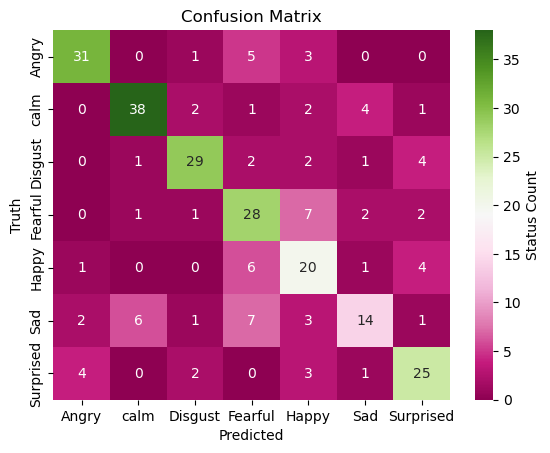

In [157]:

cm = confusion_matrix(y_test, y_pred)
classes = ['Angry', 'calm', 'Disgust', 'Fearful', 'Happy', 'Sad', 'Surprised']
s=sb.heatmap(cm, annot=True, cbar_kws={'label': 'Status Count'}, fmt='d',
           cmap="PiYG", xticklabels=classes, yticklabels=classes)
s.set(xlabel='Predicted')
s.set(ylabel='Truth')
plt.title("Confusion Matrix")

- Classification_report

In [158]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.82      0.78      0.79        40
        calm       0.83      0.79      0.81        48
     disgust       0.81      0.74      0.77        39
     fearful       0.57      0.68      0.62        41
       happy       0.50      0.62      0.56        32
         sad       0.61      0.41      0.49        34
   surprised       0.68      0.71      0.69        35

    accuracy                           0.69       269
   macro avg       0.69      0.68      0.68       269
weighted avg       0.70      0.69      0.69       269

